In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

*** Earth Engine *** FINAL DEADLINE: ee.Authenticate will fail after 2022-06-06. Please upgrade. https://developers.google.com/earth-engine/guides/python_install


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
# 定义参数
region = 'wuhan'
year = '2002'
startDate = year + '-01-01'
endDate = year + '-12-31'

In [4]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,9)

In [5]:
## 指数的计算
def water_index(img):
    image = img
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    cwi=image.select('B3').divide(image.select('B6')).rename("CWI")
    awei = image.expression('(B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7)/10000',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    ewi = image.expression('(B3 - B5 - B6)/(B3 + B5 + B6)',
        {
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
        }).rename('EWI')
    evi = image.expression('2.5*(B5 - B4)/(B5 + 6*B4 - 7.5*B2 + 1)',
        {
          'B2': image.select('B2'),
          'B4': image.select('B4'),
          'B5': image.select('B5'),    
        }).rename('EVI')
    return image.addBands(ndvi).addBands(ndwi).addBands(mndwi).addBands(cwi).addBands(awei).addBands(ewi).addBands(evi).addBands(ndvi_mndwi)

elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(outlier)

def maskSR_reverse(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    image_cloud = img.updateMask(mask.remap([0,1],[1,0]))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image_shadow = img.updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True).remap([0,1],[1,0]))
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    image_outlier = img.updateMask(bands.gt(0).rename('outlier'))
    return ee.ImageCollection([image_cloud,image_shadow,image_outlier]).sum()

# 图像可视化参数
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}

# 数据集

In [ ]:
# # dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
# #             .filterDate('2020-07-15', '2020-08-30') \
# #             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
# #             .filterBounds(roi)
# # print(dataset.size().getInfo())
# # print(dataset.aggregate_array('system:id').getInfo())

# # sentinel-2
# # 加载sentinel 图像
# def maskS2clouds(image):
#     qa = image.select('QA60')
#     cloudBitMask = 1 << 10
#     cirrusBitMask = 1 << 11
#     mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
#              .And(qa.bitwiseAnd(cirrusBitMask).eq(0))
#     return image.updateMask(mask).divide(10000)
# # sen1 = ee.Image('COPERNICUS/S2_SR/20200305T025609_20200305T030515_T50RLU')
# # sen2 = ee.Image('COPERNICUS/S2_SR/20200305T025609_20200305T030515_T50RKU')
# # sen3 = ee.Image('COPERNICUS/S2_SR/20200305T025609_20200305T030515_T50RKV')
# # sen4 = ee.Image('COPERNICUS/S2_SR/20200305T025609_20200305T030515_T50RLV')
# sen1 = ee.Image('COPERNICUS/S2_SR/20200817T025551_20200817T030350_T49RGP')
# sen2 = ee.Image('COPERNICUS/S2_SR/20200817T025551_20200817T030350_T50RKU')
# sen3 = ee.Image('COPERNICUS/S2_SR/20200817T025551_20200817T030350_T50RKV')

# sen14 = ee.ImageCollection([sen1,sen2,sen3])
# # sen14 = ee.ImageCollection([sen1,sen2])
# Map.addLayer(maskS2clouds(sen14.mosaic().clip(roi)),{'min': 0.0,'max': 0.3,'bands': ['B8', 'B4', 'B3']},'sen14')

In [ ]:
# l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate('2015-01-01','2015-12-31').filter(ee.Filter.lt('CLOUD_COVER',5))
# print(l8.aggregate_array('system:id').getInfo())

# l5 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(roi).filterDate('2002-01-01','2002-12-31').filter(ee.Filter.lt('CLOUD_COVER',10))
# print(l5.aggregate_array('system:id').getInfo())

In [ ]:
#  'LANDSAT/LE07/C01/T1_SR/LE07_123039_20020319',
#  'LANDSAT/LE07/C01/T1_SR/LE07_123039_20020709',
#  'LANDSAT/LE07/C01/T1_SR/LE07_123039_20021013'

a = ee.Image('LANDSAT/LE07/C01/T1_SR/LE07_123039_20020709').select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
# a = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_120028_20200526')
image = maskSR(water_index(a))
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
Map.addLayer(image.clip(roi), visParams,'image')
Map

In [ ]:
114.3920, 30.5956,114.4678, 30.6629

In [ ]:
# 'LANDSAT/LC08/C01/T1_SR/LC08_122039_20150103', 
#  'LANDSAT/LC08/C01/T1_SR/LC08_122039_20150831', 
#  'LANDSAT/LC08/C01/T1_SR/LC08_122039_20151002', 
#  'LANDSAT/LC08/C01/T1_SR/LC08_122039_20151018', 
 
#  'LANDSAT/LC08/C01/T1_SR/LC08_123039_20150331', 
#  'LANDSAT/LC08/C01/T1_SR/LC08_123039_20151025', 
#  'LANDSAT/LC08/C01/T1_SR/LC08_123039_20151126'

# image = maskSR(water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_123039_20151025')))
# visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
# Map.addLayer(image.clip(roi), visParams,'image')

# k-mean聚类，RF训练

In [ ]:
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
# cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft
# k-mean聚类
def k_mean(sampleSET):
    clusterer = ee.Clusterer.wekaKMeans(2).train(sampleSET,bands)
    result = sampleSET.cluster(clusterer)
    right = result.map(Compare).filter(ee.Filter.eq('eq',0))
    error = result.map(Compare).filter(ee.Filter.eq('eq',1))
    filtered_sample = ee.FeatureCollection(ee.Algorithms.If(right.size().gt(error.size()),right,error))
    return filtered_sample

In [ ]:
region = 'wuhan'
sample_region = 'WUHAN'

In [ ]:
def sumSquare(i,histogram,counts,means,size,mean):
    aCounts = counts.slice(0, 0, i)
    aCountTotal = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
    aMeans = means.slice(0, 0, i)
    aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(aCountTotal)
       
    bCounts = counts.slice(0, i, size)
    bCountTotal = bCounts.reduce(ee.Reducer.sum(), [0]).get([0])
    bMeans = means.slice(0, i, size)
    bMean = bMeans.multiply(bCounts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(bCountTotal)

    return aCountTotal.multiply(aMean.subtract(mean).pow(2)).add(bCountTotal.multiply(bMean.subtract(mean).pow(2)))
# 'B5_histogram'和 polygon、B5 要根据情景进行变更,
# Return the DN that maximizes interclass variance in B5 (in the region).

def otsu(image,band):
    histogram = image.select(band).reduceRegion(**{
        'reducer': ee.Reducer.histogram(100),
        'geometry': image.geometry(), 
        'scale': 30,
        'bestEffort': True
    })
    counts = ee.Array(ee.Dictionary(histogram.get(band)).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram.get(band)).get('bucketMeans'))
    size = means.length().get([0])
    mean = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(counts.reduce(ee.Reducer.sum(), [0]).get([0]))
    
    indices = ee.List.sequence(1,size)
    # Compute between sum of squares, where each mean partitions the data.
    bss = indices.map(lambda i : sumSquare(i,histogram.get(band),counts,means,size,mean))
    # Return the mean value corresponding to the maximum BSS.
    return means.sort(bss).get([-1])

threshold = otsu(image,'AWEI')
print(threshold.getInfo())
threshold = otsu(image,'NDWI')
print(threshold.getInfo())
threshold = otsu(image,'mNDWI')
print(threshold.getInfo())

In [ ]:
awei = image.select('AWEI').gt(-0.1)
Map.addLayer(awei.clip(roi).selfMask(),{'palette':['#FFC0CB']},'awei -0.1')

awei = image.select('AWEI').gt(-0.05)
Map.addLayer(awei.clip(roi).selfMask(),{'palette':['#FF00FF']},'awei -0.05')

awei = image.select('AWEI').gt(0)
Map.addLayer(awei.clip(roi).selfMask(),{'palette':['#9400D3']},'awei 0')

awei = image.select('AWEI').gt(0.05)
Map.addLayer(awei.clip(roi).selfMask(),{'palette':['#7B68EE']},'awei 0.05')

awei = image.select('AWEI').gt(0.1)
Map.addLayer(awei.clip(roi).selfMask(),{'palette':['#87CEEB']},'awei 0.1')

In [ ]:
NDWI = image.select('NDWI').gt(-0.1)
Map.addLayer(NDWI.clip(roi).selfMask(),{'palette':['#FFC0CB']},'NDWI -0.1')

NDWI = image.select('NDWI').gt(-0.05)
Map.addLayer(NDWI.clip(roi).selfMask(),{'palette':['#FF00FF']},'NDWI -0.05')

NDWI = image.select('NDWI').gt(0)
Map.addLayer(NDWI.clip(roi).selfMask(),{'palette':['#9400D3']},'NDWI 0')

NDWI = image.select('NDWI').gt(0.05)
Map.addLayer(NDWI.clip(roi).selfMask(),{'palette':['#7B68EE']},'NDWI 0.05')

NDWI = image.select('NDWI').gt(0.1)
Map.addLayer(NDWI.clip(roi).selfMask(),{'palette':['#87CEEB']},'NDWI 0.1')

In [ ]:
# 

awei = image.select('AWEI').gt(-0.05)
Map.addLayer(awei.clip(roi).selfMask(),{'palette':['#16d60a']},'awei')

ndwi = image.select('NDWI').gt(-0.27355410161825855)
Map.addLayer(ndwi.clip(roi).selfMask(),{'palette':['#cad60d']},'ndwi')

mndwi = image.select('mNDWI').gt(0.038991663923378966)
Map.addLayer(mndwi.clip(roi).selfMask(),{'palette':['green']},'mndwi')

In [ ]:
totalSamples = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_9920' + '_v2')
print(totalSamples.size().getInfo())
label = 'waterclass'
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
trainedClassifier = ee.Classifier.smileRandomForest(150).train(totalSamples,label,bands)
new_result = image.select(bands).classify(trainedClassifier).eq(1).rename('waterclass') 
Map.addLayer(new_result.clip(roi).selfMask(),{'palette':['blue']},"new_result") 

In [ ]:
a = ee.FeatureCollection('users/311605001111/auto_sample_awei0/' + region + '_' +year)
totalSamples = k_mean(a)
print(totalSamples.size().getInfo())
label = 'waterclass'
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
trainedClassifier2 = ee.Classifier.smileRandomForest(150).train(totalSamples,label,bands)
old_result = image.select(bands).classify(trainedClassifier2).eq(1).rename('waterclass') 
Map.addLayer(old_result.clip(roi).selfMask(),{'palette':['purple']},"old_result") 

In [ ]:
q = new_result.subtract(mndwi)
Map.addLayer(q.clip(roi),{'palette':['red','white','blue']},"q")


In [ ]:
diff = new_result.multiply(2).add(mndwi)
Map.addLayer(diff.clip(roi).selfMask(),{'palette':['red','green','blue'],'min':1,'max':3},"diff") 

In [ ]:
re = [113.7393, 29.8642,115.0993, 30.9242]
blend = diff.clip(roi).selfMask().visualize(**{'palette':['red','green','blue'],'min':1,'max':3})
# refer_img = image.visualize(**visParams)
# blend = refer_img.blend(pw)
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(blend, region=re)
cartoee.add_gridlines(ax, interval=[0.3,0.2], linestyle=":")
ax.set_title(label = 'our result VS mNDWI', fontsize=28)
# ax.set_title(label = 'Raw image (20020709)', fontsize=28)

In [ ]:
def sumSquare(i,histogram,counts,means,size,mean):
    aCounts = counts.slice(0, 0, i)
    aCountTotal = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
    aMeans = means.slice(0, 0, i)
    aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(aCountTotal)
       
    bCounts = counts.slice(0, i, size)
    bCountTotal = bCounts.reduce(ee.Reducer.sum(), [0]).get([0])
    bMeans = means.slice(0, i, size)
    bMean = bMeans.multiply(bCounts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(bCountTotal)

    return aCountTotal.multiply(aMean.subtract(mean).pow(2)).add(bCountTotal.multiply(bMean.subtract(mean).pow(2)))
# Return the DN that maximizes interclass variance in B5 (in the region).
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    mean = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(counts.reduce(ee.Reducer.sum(), [0]).get([0]))
    indices = ee.List.sequence(1,size)
    bss = indices.map(lambda i : sumSquare(i,histogram,counts,means,size,mean))
    # Return the mean value corresponding to the maximum BSS.
    return means.sort(bss).get([-1])

band = 'AWEI'
def histogram(image):
    dict = band + "_" + 'histogram'
    hist = image.select(band).reduceRegion(**{
        'reducer': ee.Reducer.histogram(100).combine(ee.Reducer.mean(),'',True).combine(ee.Reducer.variance(),'',True),
        'geometry': image.geometry(), 
        'scale': 30,
        'bestEffort': True
    })
    return hist.get(dict)
hist = otsu(histogram(image.select(band)))
print(hist.getInfo())

band = 'NDWI'
def histogram(image):
    dict = band + "_" + 'histogram'
    hist = image.select(band).reduceRegion(**{
        'reducer': ee.Reducer.histogram(100).combine(ee.Reducer.mean(),'',True).combine(ee.Reducer.variance(),'',True),
        'geometry': image.geometry(), 
        'scale': 30,
        'bestEffort': True
    })
    return hist.get(dict)
hist = otsu(histogram(image.select(band)))
print(hist.getInfo())

band = 'mNDWI'
def histogram(image):
    dict = band + "_" + 'histogram'
    hist = image.select(band).reduceRegion(**{
        'reducer': ee.Reducer.histogram(100).combine(ee.Reducer.mean(),'',True).combine(ee.Reducer.variance(),'',True),
        'geometry': image.geometry(), 
        'scale': 30,
        'bestEffort': True
    })
    return hist.get(dict)
hist = otsu(histogram(image.select(band)))
print(hist.getInfo())

In [ ]:
awei = image.select('AWEI').gt(0)
Map.addLayer(awei.selfMask(),{'palette':['#16d60a']},'awei')

ndwi = image.select('NDWI').gt(0)
Map.addLayer(ndwi.selfMask(),{'palette':['#cad60d']},'ndwi')

mndwi = image.select('mNDWI').gt(0)
Map.addLayer(mndwi.selfMask(),{'palette':['#7960ff']},'mndwi')

# 制图

In [ ]:
# 114.6317, 30.1124,114.6568, 30.1340
# 113.7392, 30.1330,113.7615, 30.1532
# 113.7787, 30.1473, 113.8156, 30.1801

In [6]:
region = 'wuhan'
sample_region = 'WUHAN'

Text(0.5, 1.0, 'Raw image (20020709)')

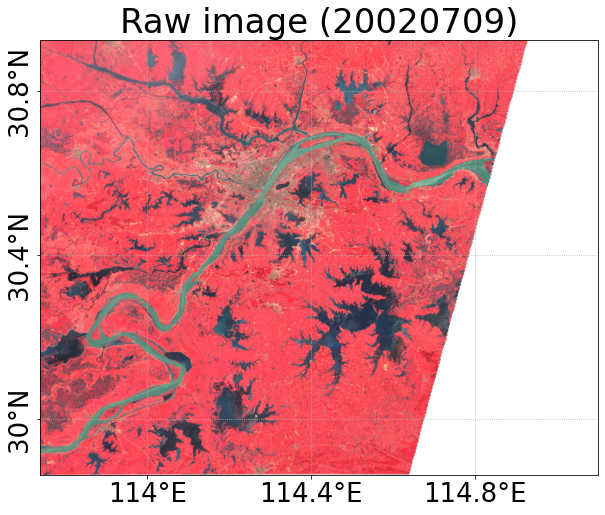

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# 建筑物阴影
# re = [114.4152, 30.5962,114.4717, 30.6458]
# re = [114.3920, 30.5956,114.4678, 30.6629]

# re = [113.8349, 30.8312,113.9636, 30.9237]
re = [115.0993, 29.8642, 113.7393, 30.9242]
# re = [114.6579, 30.4839,114.7090, 30.5253]
# re = [114.0277, 30.7507,114.1081, 30.8262]


visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
# image = water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_123039_20151025')).clip(roi)
# image = maskSR(water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_123039_20200413'))).clip(roi)

a = ee.Image('LANDSAT/LE07/C01/T1_SR/LE07_123039_20020709').select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
# image = maskSR(water_index(a)).clip(roi)
image = water_index(a).clip(roi)

refer_img = image.visualize(**visParams)
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(refer_img, region=re)
cartoee.add_gridlines(ax, interval=[0.4,0.4], linestyle=":", ytick_rotation="vertical")
# cartoee.add_gridlines(ax, interval=[0.03,0.02], linestyle=":")
ax.tick_params(labelsize=26)
ax.set_title(label = 'Raw image (20020709)', fontsize=34)

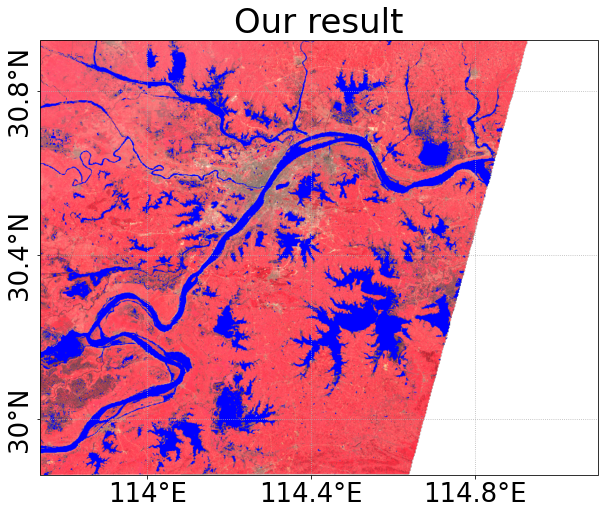

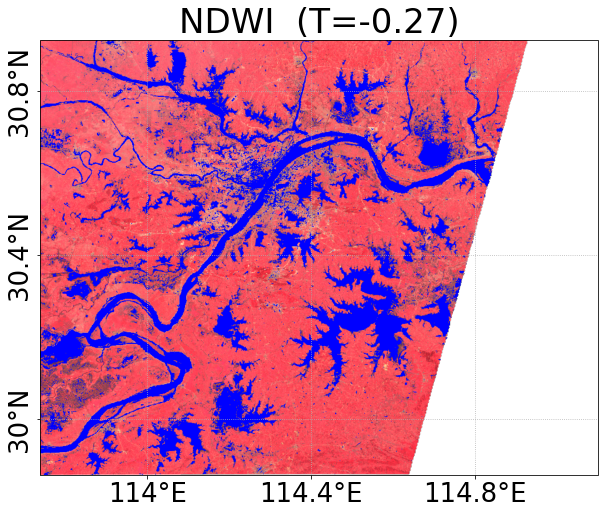

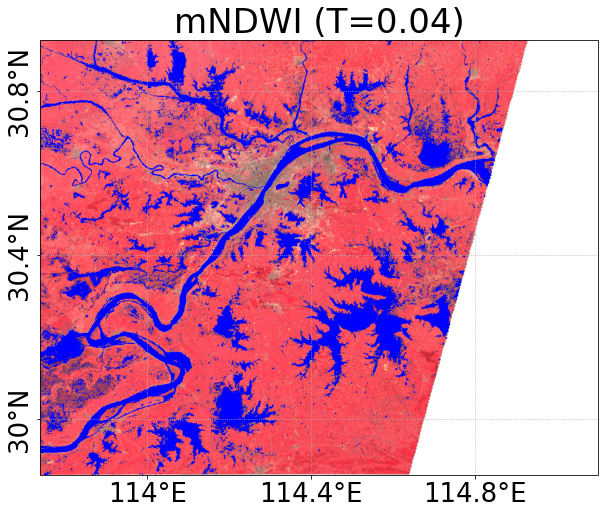

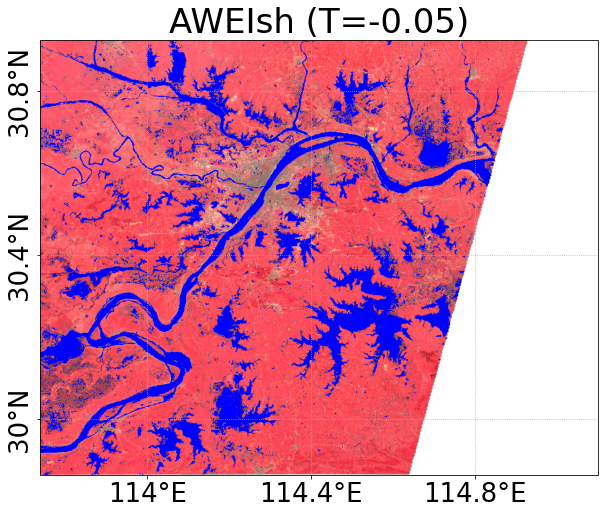

In [9]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

item = [['new_result','Our result'],['ndwi','NDWI  (T=-0.27)'],['mndwi','mNDWI (T=0.04)'],['awei','AWEIsh (T=-0.05)']]
# 建筑物阴影
# re = [114.4152, 30.5962,114.4717, 30.6458]
# re = [114.3920, 30.5956,114.4678, 30.6629]

# re = [113.8349, 30.8312,113.9636, 30.9237]
re = [115.0993, 29.8642, 113.7393, 30.9242]
# re = [114.6579, 30.4839,114.7090, 30.5253]
# re = [114.0277, 30.7507,114.1081, 30.8262]

visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
# image = maskSR(water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_123039_20200413'))).clip(roi)
# image = water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_123039_20151025')).clip(roi)

a = ee.Image('LANDSAT/LE07/C01/T1_SR/LE07_123039_20020709').select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
# image = maskSR(water_index(a)).clip(roi)
image = water_index(a).clip(roi)

for it in item:
    if it[0] == 'new_result':
        totalSamples = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_9920' + '_v2')
        label = 'waterclass'
        bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
        trainedClassifier = ee.Classifier.smileRandomForest(150).train(totalSamples,label,bands)
        classify_result = image.select(bands).classify(trainedClassifier).eq(1).rename('waterclass')  
    elif it[0] == 'ndwi':
        classify_result = image.select('NDWI').gt(-0.27355410161825855)
    elif it[0] == 'mndwi':
        classify_result = image.select('mNDWI').gt(0.038991663923378966)
    elif it[0] == 'awei':
        classify_result = image.select('AWEI').gt(-0.05)
    refer_img = image.visualize(**visParams)
    pw = classify_result.selfMask().visualize(**{'palette':['blue']})
    blend = refer_img.blend(pw)
    fig = plt.figure(figsize=(12, 8))
    ax = cartoee.get_map(blend, region=re)
    cartoee.add_gridlines(ax, interval=[0.4,0.4], linestyle=":", ytick_rotation="vertical")
    # cartoee.add_gridlines(ax, interval=[0.03,0.02], linestyle=":")
    ax.tick_params(labelsize=26)
    ax.set_title(label = it[1], fontsize=34)

# 制图--1

In [ ]:
# region = [114.5845, 30.3420, 114.6457, 30.3818]
region = [113.7448, 30.0799, 113.7905, 30.1074]

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
refer_img = image.visualize(**visParams)
pw = classify_image5.selfMask()
blend = refer_img.blend(pw.visualize(**{'palette':['yellow']})).blend(classify_image1.selfMask().visualize(**{'palette':['#7960ff']}))
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(blend, region=region)
label = 'scheme A vs scheme E'
ax.set_title(label = label, fontsize=28)